In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import generic libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.io
import os, sys

In [1248]:
# Import local tools
from mult_util import mult_fz_util

In [1249]:
# Import local OASIS installation
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [1250]:
# Set file-name and path to analyze
stringid = "CGCC8.4a"
filename = os.path.expanduser('/Users/mariangelapanniello/Desktop/ca-data-large/%s.mat'%stringid)

In [1251]:
# Load data struct
dat = utils.load_mat_file(filename)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [1252]:
# Print contents
print("subject: %s"%stringid)
utils.print_file_content(dat)

subject: CGCC8.4a
imaging/
 date_2017_12_05
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour
 date_2017_12_13
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour
 date_2017_12_14
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour
 ->area4
  ->plane1
  ->plane2
  ->session_behaviour
 date_2017_12_15
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour


In [1253]:
expspecifier = "date_2017_12_14/area4"
path="imaging/%s"%expspecifier
area=dat.get(path)
utils.get_hdf5group_keys(area)

['plane1', 'plane2', 'session_behaviour']

In [1254]:
plane1=area['plane1']
plane2=area['plane2']
sessbehav=area['session_behaviour']

In [1255]:
print(utils.get_hdf5group_keys(sessbehav))

['ID', 'area', 'area1', 'area2', 'area3', 'correct_trials', 'correctrejection_trials', 'date', 'falsepositive_trials', 'initial_trials', 'licks', 'mid_time_bins', 'missed_trials', 'motor_start', 'runEvents', 'running_backward', 'running_forward', 'sessionType', 'session_length', 'trialType', 'water_delivered']


In [1256]:
# Extract frame rate from struct
# print(utils.get_hdf5group_keys(area['plane1']))
frate = area['plane1/fRate'][0,0]
print("Frame rate %f"%frate)

Frame rate 15.025000


In [1257]:
# Merge fluorescence corrected from multiple planes
fluo = np.concatenate([plane1['fluoresence_corrected'], plane2['fluoresence_corrected']],axis=1).T
time = np.arange(len(fluo.T))*1.0/frate

In [1258]:
# Extract event timing
event_fields = ['motor_start', 'running_forward', 'licks', 'water_delivered', 'correct_trials', 'missed_trials']
events = {}
for f in event_fields:
    events[f] = np.array(sessbehav[f])
t_stim = events['motor_start']

In [1259]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    # simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    # simpleaxis(plt.gca())
    print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

In [1260]:
# Init values for OASIS
tau_d = 140e-3
tau_r = 45e-3
g1 = np.exp(-1/(tau_d*frate))+np.exp(-1/(tau_r*frate))
g2 = -np.exp(-1/(tau_d*frate))*np.exp(-1/(tau_r*frate))

# ginit = (g1,g2) # Double exponential, fix time constant
# ginit=(None,None) # Double exponential, fit time constant
# ginit = (0.95,) # Single exponential, fix time constant
ginit=(None,) # Single exponential, fit time constant

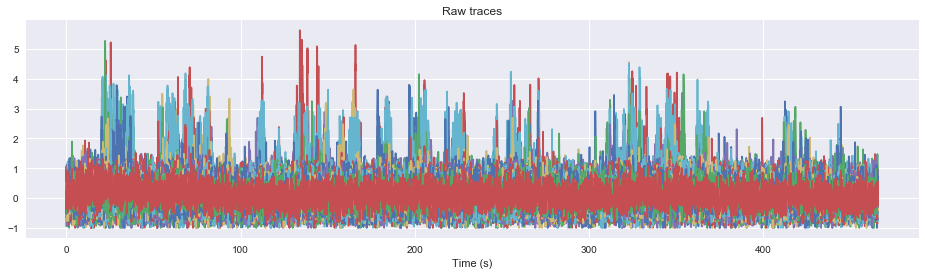

In [1261]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.title("Raw traces")
plt.xlabel("Time (s)")
sns.despine()

In [1262]:
# Run OASIS on each fluorescence trace
traces = []
gvalues = []
for idx in range(len(fluo)):
    y = np.array(fluo[idx],dtype=float)
    c, s, b, g, lam = deconvolve(y, g=ginit, penalty=1)
    traces.append(c)
    gvalues.append(g)
traces = np.array(traces)

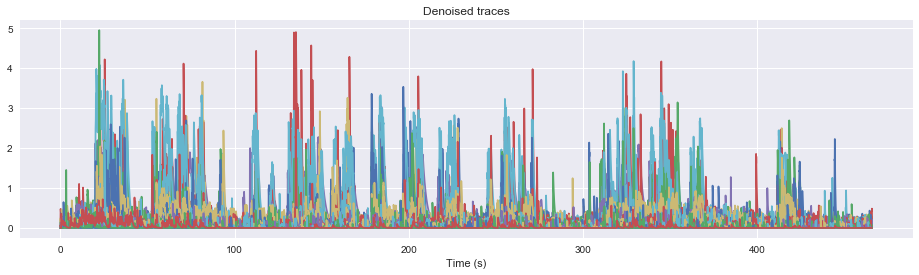

In [1263]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, traces.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.xlabel("Time (s)")
plt.title("Denoised traces")
sns.despine()

# A look at effective data dimension with PCA

In [1264]:
from sklearn.decomposition import PCA, NMF
nb_components = 20

In [1265]:
X = np.array(fluo.T)
time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_raw = np.cumsum(pca.explained_variance_ratio_)

In [1266]:
X = np.array(traces.T)
time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_denoised = np.cumsum(pca.explained_variance_ratio_)

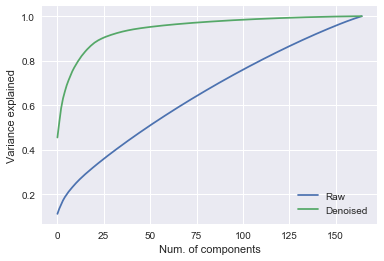

In [1267]:
plt.plot(varexp_raw, label="Raw")
plt.plot(varexp_denoised, label="Denoised")
plt.legend()
plt.xlabel("Num. of components")
plt.ylabel("Variance explained")

# Non-negative matrix factorization

In [1268]:
nb_components = 20
nmf = NMF(n_components=nb_components, random_state=1, alpha=0.1, l1_ratio=0.5)
nmf.fit(X)

NMF(alpha=0.1, beta=1, eta=0.1, init=None, l1_ratio=0.5, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [1269]:
nmf_tarnsformed = nmf.transform(X)

In [1270]:
def plot_events(ev_names, y_offset=1.0, y_scale=0.1):
    cols = ["black", "gray", "darkblue", "darkred", "darkgreen", "magenta", "cyan"]
    for i,label in enumerate(event_fields):
        t_event = events[label]/frate
        y = (y_offset + y_scale*i)*np.ones(t_event.shape)
        plt.scatter(t_event,y,c=cols[i],label=label)

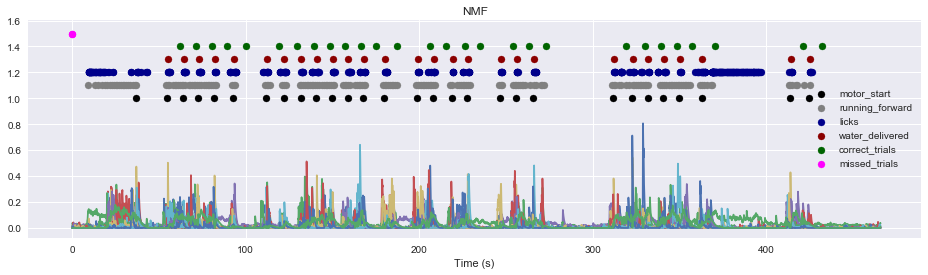

In [1271]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
plot_events(event_fields)
plt.title("NMF")
plt.xlabel("Time (s)")
plt.legend(loc='best')
sns.despine()

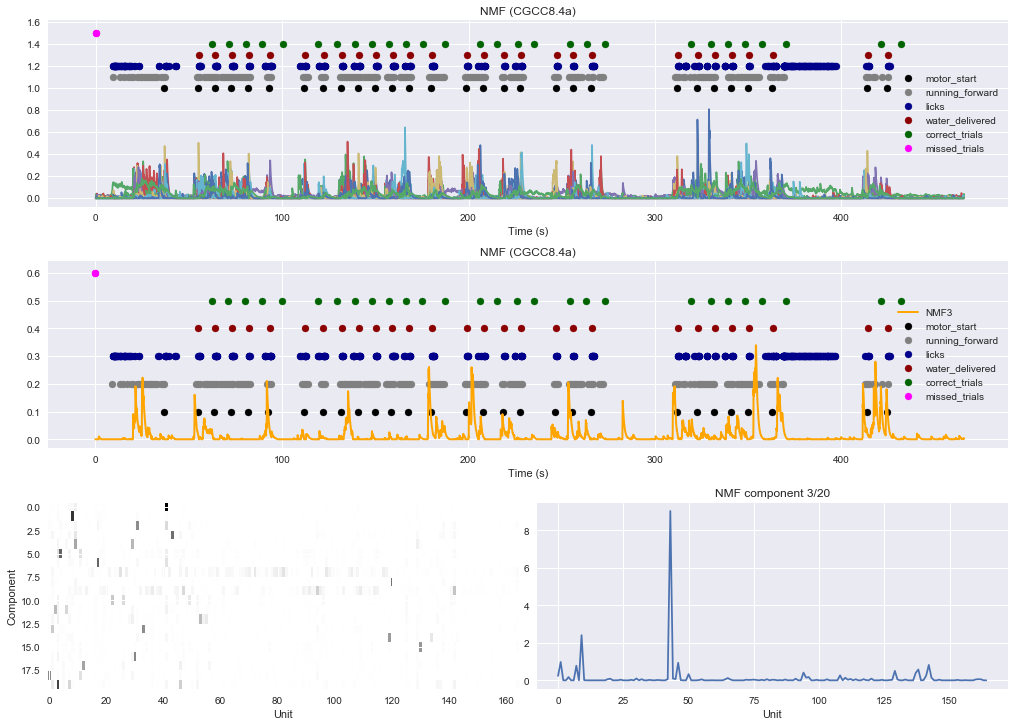

In [1272]:
plt.figure(figsize=(14,10))

plt.subplot(3,1,1)
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
plot_events(event_fields)
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
#plt.xlim((200,320))

compid = 3
plt.subplot(3,1,2)
plot_events(0.2,0.1)
p0 = plt.plot(time, nmf_tarnsformed[:,compid], c='orange', linewidth=2, label="NMF%i"%(compid))
p0 = plt.plot(time, nmf_tarnsformed[:,compid], c='orange', linewidth=2, label="NMF%i"%(compid))
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
#plt.xlim((150,280))

plt.subplot(3,2,5)
plt.tight_layout()
plt.imshow(nmf.components_,aspect="auto")
plt.xlabel("Unit")
plt.ylabel("Component")

plt.subplot(3,2,6)
plt.plot(nmf.components_[compid])
plt.xlabel("Unit")
plt.title("NMF component %i/%i"%(compid,nb_components))
sns.despine()

# Under construction

In [1273]:
print(1/0)

ZeroDivisionError: division by zero

# Generate dataset for supervised learning

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [ ]:
# Build delay embedded data
embedding_dim = 10
nb_frames = len(fluo.T)-embedding_dim
x_raw  = fluo.T
# x_data = np.zeros((nb_frames, x_raw.shape[1]*embedding_dim))
x_data = []
print(x_raw.shape[1]*embedding_dim)
for i in range(nb_frames):
    if i < embedding_dim//2 or i > nb_frames-embedding_dim//2:
        continue
    x_data.append(x_raw[i-embedding_dim//2:i+embedding_dim//2].ravel())
    
# Build labels
# TODO broken below
target_events = event_fields
y_data = np.zeros((len(x_data),len(event_fields)))
# y_data = []
for i,ev in enumerate(event_fields):
    for frame in frames:
        pos = int(events[ev][frame])
        y_data[pos,i] = 1
# plt.imshow(y_data, aspect='auto')
# Shuffle data set
idx = np.arange(len(x_data),dtype=int)
x_data = np.array(x_data)[idx]
y_data = np.array(y_data)[idx]

In [ ]:
print(y_data)

In [ ]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

In [ ]:
# Split train and validation set
split = 0.2
pivot = int(split*len(x_data))
x_train = x_data[:pivot]
y_train = y_data[:pivot]
x_valid = x_data[pivot:]
y_valid = y_data[pivot:]

# Training a linear classifier on predicting events

In [ ]:
def compute_chance_level(y, nb_stats=10):
    """ Computes chance level by matching the mean event rate and then drawing random samples. 
    
    params
        y : a one dimensional array with labels/events zero or one 
    
    returns
        a float corresponding to chance level
    """
    m = y.mean()
    evals = []
    for i in range(nb_stats):
        y_surrogate = np.random.rand(*y.shape)<m
        pred= y_surrogate
        acc = (pred==y).mean()
        evals.append(acc)
    evals = np.array(evals)
    return evals.mean(), evals.std()

In [ ]:
for comp_id,ev in enumerate(event_fields):
    print("Training linear SVC on %s events"%event_fields[comp_id])
    C = 1.0  # SVM regularization parameter
    svc=svm.SVC(kernel='linear', C=C)
    svc.fit(x_train, y_train[:,comp_id])
    pred = svc.predict(x_train)
    train_acc = (pred==y_train[:,comp_id]).mean()
    print("%.3f train_acc"%train_acc)
    pred = svc.predict(x_valid)
    valid_acc = (pred==y_valid[:,comp_id]).mean()
    # TODO add chance level for comparison
    print("%.3f valid_acc"%valid_acc)
    print(r"%.3f ± %.3f chance"%compute_chance_level(y_train[:,comp_id]))
    print()